In [1]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import matplotlib

default_backend = matplotlib.get_backend()

In [2]:
def plot(cy, mod, title, out_file, just_show = False):
    cylon_df = pd.read_csv(cy)
    modin_df = pd.read_csv(mod)

    cylon_avg = sqldf("SELECT world, avg(time) as avg FROM cylon_df GROUP BY world", locals())
    modin_avg = sqldf("SELECT world, avg(time) as avg FROM modin_df GROUP BY world", locals())

    scalar = sqldf("SELECT cy.world, cy.avg AS cylon, md.avg AS modin FROM cylon_avg cy JOIN modin_avg md ON cy.world = md.world", locals())


    if not just_show:
        matplotlib.use("pgf")
        matplotlib.rcParams.update({
            "pgf.texsystem": "xelatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
        })
    else:
        matplotlib.use(default_backend)

    scalar.plot(x="world", logy=True, logx=True,xticks = scalar['world'], ylabel='time(ms)', title=title)

    if just_show:
        plt.show()

    if not just_show:
        plt.savefig(out_file)


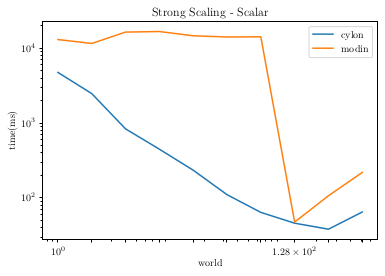

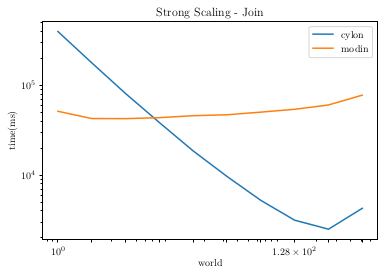

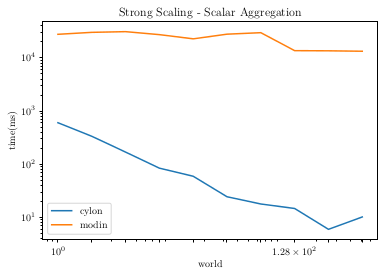

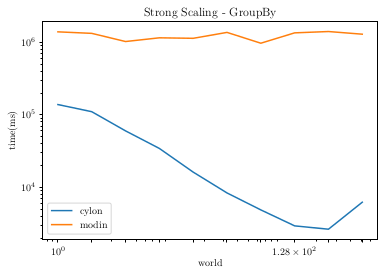

In [4]:
just_show = False

plot('resultsgraphs/scalar.csv', 'resultsgraphs/modin_scalar.csv', 'Strong Scaling - Scalar', 'scalar.pgf', just_show)
plot('resultsgraphs/join.csv', 'resultsgraphs/modin_join.csv', 'Strong Scaling - Join', 'join.pgf', just_show)
plot('resultsgraphs/scalar-agg.csv', 'resultsgraphs/modin_scalar_agg.csv', 'Strong Scaling - Scalar Aggregation', 'scalar-agg.pgf', just_show)
plot('resultsgraphs/groupby.csv', 'resultsgraphs/modin_groupby.csv', 'Strong Scaling - GroupBy', 'groupby.pgf', just_show)